scatter plot of identity Vs. 3' /5' length

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from typing import List,Tuple,Callable

from sklearn.linear_model import LinearRegression
from math import log2

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap,Normalize,FuncNorm
import matplotlib.patches as patches
from matplotlib.axes import Axes
# from foreground import get_foreground 
from dna_features_viewer import GraphicFeature, GraphicRecord

In [7]:

def parse_diamond(matchfile:str='diamond-matches.tsv')->pd.DataFrame:
    '''
    matchfile:
        output of diamond blastp
        with '--header', 'verbose', 
        and 'tsv' suffix
    '''
    head_lines=open(matchfile,'r').readlines()[2].strip().split(': ')[1]
    diamond_aligns=pd.read_csv(matchfile,skiprows=3,names=head_lines.split(', '),sep='\s+')
    return diamond_aligns

def get_identities(fasta_path:str):
    '''
    from diamond tsv
    to df of ['domain','virus','identity']
    '''
    o_dict={}
    _={}
    _['domain'],_['virus'],_['identity']=[],[],[]
    for i in Path(fasta_path).iterdir():
        if i.suffix=='.tsv':
            stem=i.stem.replace('-match','')
            diamond=parse_diamond(i.absolute())
            o_dict[stem]={i:j for i,j in zip(diamond['Subject ID'],diamond['Percentage of identical matches'])}
            for idx,s in diamond.iterrows():
                _['domain'].append(stem)
                _['virus'].append(s['Subject ID'])
                _['identity'].append(s['Percentage of identical matches'])
    identities=pd.DataFrame(_)
    # identities.columns
    return o_dict,identities

def cal_lr(x,y,refx=np.linspace(1,100,100)):
    lr=LinearRegression()
    x_=np.array(x).reshape(-1,1)
    y_=np.array(y).reshape(-1,1)
    reg=lr.fit(X=x_,y=y_)
    r2=reg.score(x_,y_)
    coef=reg.coef_[0][0]
    intercept=reg.intercept_[0]
    
    predy=reg.predict(refx.reshape(-1,1))
    sel=(predy>0) & (predy<100)
    
    reg_x=refx[sel.reshape(-1)].reshape(-1)
    reg_y=predy[sel].reshape(-1)
    
    return (
        coef,intercept,r2,
        reg_x,reg_y,
    )
    
def get_lr_cohort(identities_dict:dict,
                  ref_genome:str,
                  ref_accession:str):
    '''use `identity_dict` from `get_identities`'''
    o_dict={}
    for accession,d in identities_dict.items():
            # if accession!=ref_accession:
            x,y=[],[]
            for k in d.keys():
                if k !=ref_genome:
                    r=identities_dict[ref_accession].get(k,None)
                    if r is not None:
                        x.append(r)
                        y.append(d[k])
            if len(x)>0:
                o_dict[accession]=(x,y)
    return o_dict



def get_ref_palette(accession:str,
                    lr_metrics:dict,
                    corr_color_map:LinearSegmentedColormap,
                    fetch=lambda x: x[0],
                    transform=lambda x: 1-log2(x)):
    '''
    `lr_metrics` comes from `{k:cal_lr(v[0],v[1]) for k,v in lr_cohort.items()}`,
        where `lr_cohort` comes from get_lr_cohort
    `fetch`: fetch metric values from lr_metrics' dict
    `trasnform`: metric values mapping (usually to 0~1)
    '''
    if accession in lr_metrics:
        # ref_c=corr_color_map(lr_metrics[accession][2]/100-1e-10)
        m_val=transform(fetch(lr_metrics[accession]))
        ref_c=corr_color_map(m_val)
        return LinearSegmentedColormap.from_list(accession, [(1, 1, 1, 1), ref_c])
    else:
        return LinearSegmentedColormap.from_list(accession, [(1, 1, 1), (1, 0, 0)])
    
def get_missing_palette(domains:pd.DataFrame,ref_genome:str,
        missing_color_map:LinearSegmentedColormap)->Tuple[dict[str,Tuple[int]],int]:
    o_dict={}
    # total_genome=len(domains['genome_name'].unique())
    cano_entry=domains[domains['domain_accession']==ref_genome]['genome_name'].unique()
    uncano_entry=[i for i in domains['domain_accession'].unique() 
                    if i not in cano_entry]
    max_missing=max([len(domains[domains['domain_accession']==i]) for i in uncano_entry])
    for i in uncano_entry:
        l=len(domains[domains['domain_accession']==i])
        o_dict[i]=missing_color_map(l/max_missing)
    return o_dict,max_missing



def get_corr_color_map(lr_metrics:dict,fetch=lambda x: x[0],
                       colors = [mcolors.to_rgba(i) for i in ['teal','gold','orangered']]):
    _=[fetch(i) for i in lr_metrics.values()]
    metric_min,metric_max=min(_),max(_)
    # print(metric_min,metric_max)
    position_ref=(1-metric_min)/(metric_max-metric_min)
    if position_ref<=0:
        positions = [0, 1]
        situ='conserved'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors[:2])], N=512)
        
    elif 0<position_ref<1:
        positions = [0, position_ref, 1]
        situ='biased'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors)], N=512)
    else :
        positions = [0, 1]
        situ='diverged'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors[1:])], N=512)
    return corr_color_map,situ,position_ref,metric_min,metric_max

def fix_corr_color_map(lr_metrics:dict,fetch=lambda x: x[0],
                       colors = [mcolors.to_rgba(i) for i in ['teal','gold','orangered']]):
    situ='fix'
    position_ref=1/3
    metric_min,metric_max=0.5,2
    corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip([0, position_ref, 1],colors)], N=512)
    return corr_color_map,situ,position_ref,metric_min,metric_max

def hide_axes(ax:Axes,genome_start_pos:int,genome_end_pos:int,sequence_length=42000):
    '''
    hack: draw a white box over them.
    '''
    ax.add_patch(
     patches.Rectangle(
        (-100, -0.25),
        genome_start_pos,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 
    ax.add_patch(
     patches.Rectangle(
        (genome_end_pos, -0.25),
        sequence_length+100,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 

def sort_genome(genome_names:List[str],sort_rdrps:pd.DataFrame):
    o=[]
    for i in genome_names:
        if i in sort_rdrps.index:
            o.append((i,sort_rdrps.loc[i]['Percentage of identical matches']))
        else:
            o.append((i,0))
    o.sort(key=lambda x:x[1],reverse=True)
    return o

def norm(x_:float):
    # return np.sqrt(x_)
    _pseudo_index=1.5#log(log(1.5,2),0.8)
    _pseudo_identity=2**(x_**_pseudo_index)-1
    return _pseudo_identity
    
def rev_norm(y_:float):
    # return y_**2
    _pseudo_index=1.5#log(log(1.5,2),0.8)
    identity=np.log2(y_+1)**(1/_pseudo_index)
    return identity

def get_no_ref_accession_genome(
    domains:pd.DataFrame,ref_accession:str
)->List[str]:
    genomes=domains['genome_name'].unique()
    no_ref_accession_genome=[]
    for g in genomes:
        if not ((domains['genome_name']==g)&(domains['domain_accession']==ref_accession)).any():
            no_ref_accession_genome.append(g)
    return no_ref_accession_genome

def get_sequence_length(domains:pd.DataFrame,ref_accession:str,paddding=1000):
    _=domains[domains['domain_accession']==ref_accession].copy(deep=True) # poor performance, could be slow
    left_=_['start']-(_['hmmStart']*3)
    right_=_['genome_length']-left_
    left,right=left_.max(),right_.max()
    no_ref_accession_genome=get_no_ref_accession_genome(domains,ref_accession)
    if len(no_ref_accession_genome)>0:
        max_unalign_length=domains[domains['genome_name'].isin(no_ref_accession_genome)]['genome_length'].max()
    else:
        max_unalign_length=0
    
    if max_unalign_length<left+right:
        sequence_length,ref=left+right+paddding*2,left+paddding
        return sequence_length,ref
    else:
        sequence_length=max_unalign_length+paddding*2
        ref=left+paddding+(sequence_length-(left+right))/2
    # left,right=max(0,max_unalign_length,left_.max())+paddding,max(0,max_unalign_length,right_.max())+paddding
    # sequence_length,ref=left+right,left
    return sequence_length,ref

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1440418/2319998216.py:9: SyntaxWarning: invalid escape sequence '\s'
  diamond_aligns=pd.read_csv(matchfile,skiprows=3,names=head_lines.split(', '),sep='\s+')


In [3]:
family_dict={
    'zika':'Flaviviridae',
    'ebola':'Filoviridae',
    'measles':'Paramyxoviridae'
}
ref_genome_dict={
    'zika':'ZIKV||AY632535',
    'ebola':'EBOV||AF086833',
    'measles':'MeV||AB016162'
}
ref_accession_dict={
    'zika':'PF00972',
    'ebola':'PF00946',
    'measles':'PF00946'
}

In [4]:
from typing import Dict
def get_ends_df(domains:pd.DataFrame,
                identities_dict:Dict[str,Dict[str,float]],
                ref_accession:str):
    _=domains[domains['domain_accession']==ref_accession].copy(deep=True) # poor performance, could be slow
    _['5']=_['start']-(_['hmmStart']*3)
    _['3']=_['genome_length']-_['5']
    _.set_index('genome_name',inplace=True)
    end5_dict={}
    end3_dict={}
    for i in identities_dict[ref_accession]:
        end5_dict[i]=_.loc[i]['5']
        end3_dict[i]=_.loc[i]['3']
    ends_df=pd.DataFrame([identities_dict[ref_accession],end5_dict,end3_dict]).T
    ends_df.columns=['identity','5-length','3-length']
    return ends_df

In [5]:
k='ebola'
ref_genome=ref_genome_dict[k]
ref_accession=ref_accession_dict[k]
suffix='genlength'
def plot_genlength(k:str,ref_genome:str,ref_accession:str,suffix:str='genlength'):
    domains=pd.read_csv(f'../data/{k}/{k}-domains.csv')
    identities_dict=get_identities(f'/home/hugheslab1/zfdeng/pangenome/Step3/data/{k}/{k}_fasta')[0]
    ends_df=get_ends_df(domains,identities_dict,ref_accession)
    plt.close('all')
    fig,ax1=plt.subplots(1,1,figsize=(8,8))
    ax1:Axes
    ax1.scatter(ends_df['identity'],ends_df['5-length'],color='teal',s=25,marker='1',alpha=0.7)
    ax1.scatter(ends_df['identity'],-ends_df['3-length'],color='teal',s=25,marker='2',alpha=0.7)
    ax1.vlines(x=ends_df['identity'],ymax=ends_df['5-length'],ymin=-ends_df['3-length'],
               color='teal',linestyles='--',linewidth=0.9,alpha=0.7,)

    ax1.text(0.01, 0.98, "5' end", transform=ax1.transAxes, va='bottom', ha='left',fontsize=12)
    ax1.text(0.01, 0.02, "3' end", transform=ax1.transAxes, va='top', ha='left',fontsize=12)
    ax1.set_xlabel('identity',loc='center',labelpad=-5,fontsize=12)
    ax1.set_title(f'{k}',fontsize=18)
    ax1.text(0.95, 0.98, f"ref-genome: {ref_genome}\nref-domain: {ref_accession}", 
             transform=ax1.transAxes, va='top', ha='right')

    ax1.spines['bottom'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.set_xlim(101,0)
    ax1.set_xticks(np.linspace(100,0,6))

    fig.tight_layout()
    fig.savefig(f'{k}-{suffix}.pdf')
    plt.close('all')
# lr_cohort=get_lr_cohort(identities_dict,ref_genome,ref_accession=ref_accession)
# lr_metrics={k:cal_lr(v[0],v[1]) for k,v in lr_cohort.items()}

In [16]:
k:str='ebola'
ref_genome:str=ref_genome_dict[k]
ref_accession:str=ref_accession_dict[k]
suffix:str='genlength'
domains=pd.read_csv(f'../data/{k}/{k}-domains.csv')
identities_dict=get_identities(f'/home/hugheslab1/zfdeng/pangenome/Step3/data/{k}/{k}_fasta')[0]
ends_df=get_ends_df(domains,identities_dict,ref_accession)


In [65]:
identities_dict

{'PF05505': {'EBOV||AF086833': 100.0,
  'BDBV||FJ217161': 75.8,
  'TAFV||FJ217162': 75.7,
  'BOMV||MF319185': 72.0,
  'SUDV||AY729654': 67.7,
  'RESTV||AF522874': 67.9,
  'LLOV||JF828358': 48.7,
  'MLAV||KX371887#0': 55.2,
  'RAVV||DQ447649': 53.6,
  'MARV||DQ217792': 53.3,
  'TAPV||BR001752': 34.3,
  'XILV||MG599980': 28.2},
 'PF00946': {'EBOV||AF086833': 100.0,
  'BDBV||FJ217161': 87.3,
  'TAFV||FJ217162': 87.0,
  'BOMV||MF319185': 83.9,
  'RESTV||AF522874': 82.8,
  'SUDV||AY729654': 82.0,
  'LLOV||JF828358': 66.5,
  'MLAV||KX371887': 57.4,
  'MARV||DQ217792': 56.2,
  'RAVV||DQ447649': 56.3,
  'TAPV||BR001752': 46.1,
  'XILV||MG599980': 46.6,
  'HUJV||MG599981': 31.1,
  'OBLV||MN510773': 29.2},
 'PF02097': {'EBOV||AF086833': 100.0,
  'TAFV||FJ217162': 80.0,
  'BDBV||FJ217161': 78.6,
  'BOMV||MF319185': 77.4,
  'SUDV||AY729654': 69.2,
  'RESTV||AF522874': 68.6,
  'LLOV||JF828358': 52.1,
  'MLAV||KX371887': 35.3,
  'RAVV||DQ447649': 36.1,
  'MARV||DQ217792': 35.2},
 'PF14318': {'EBOV||

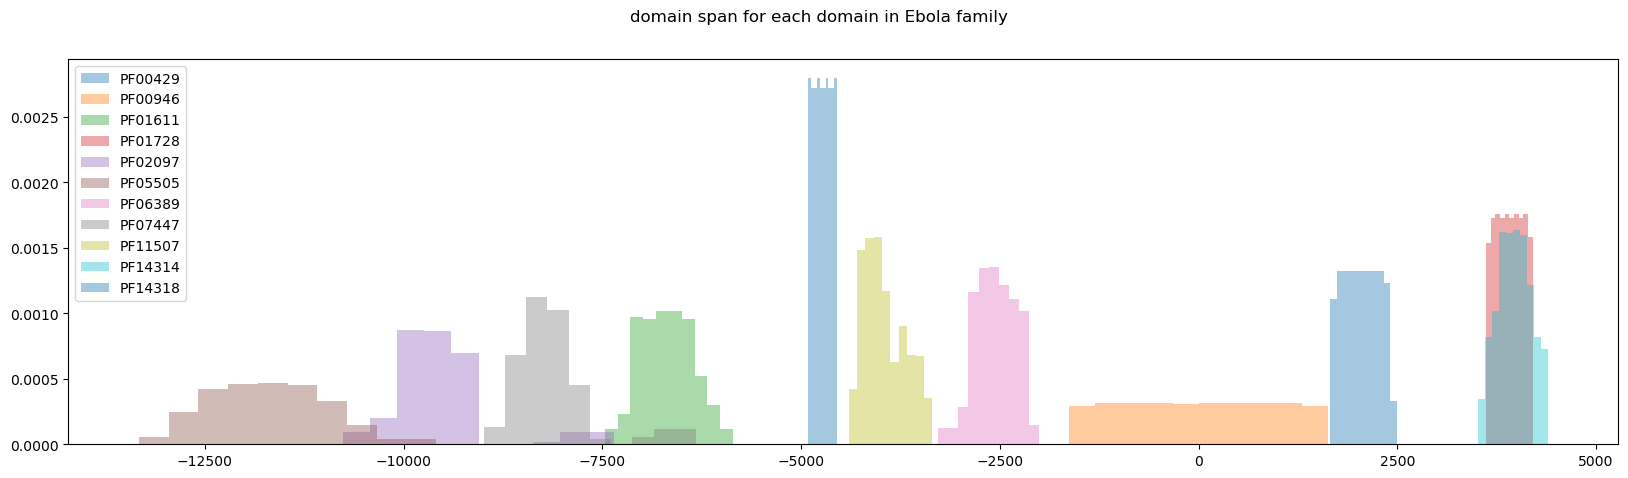

In [63]:
import numpy as np
def relative_be(row:pd.Series):
    ref0=(ref_pos[row['genome_name']]['start']+ref_pos[row['genome_name']]['end'])/2
    return int(row['start']-ref0),int(row['end']-ref0)

ref_pos={}
for k,subdf in domains.groupby('genome_name'):
    if ref_accession in subdf['domain_accession'].values:
        ref_pos[k]=subdf[subdf['domain_accession']==ref_accession].iloc[0][['start','end']].to_dict()
domains['refbe']=domains.apply(relative_be,axis=1)
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax:Axes
for k,subdf in domains.groupby('domain_accession'):
    _=np.hstack([np.linspace(b,e,e-b+1,dtype=int) for b,e in subdf['refbe']])
    ax.hist(_,density=True,label=k,alpha=0.4)
ax.legend()
fig.suptitle('domain span for each domain in Ebola family')
fig.show()

In [56]:
domains[domains['genome_name']=='EBOV||AF086833']

,genome_name,genome_length,domain_accession,strand,start,end,hmmStart,hmmEnd,evalue,domain_annotation,refbe
0,EBOV||AF086833,18959,PF06389,SENSE,10348,11098,1,262,2.100000e-141,Filo_VP24:Filovirus membrane-associated protei...,"(-2881, -2131)"
1,EBOV||AF086833,18959,PF11507,SENSE,8935,9322,1,131,2.000000e-69,Transcript_VP30:Ebola virus-specific transcrip...,"(-4294, -3907)"
2,EBOV||AF086833,18959,PF07447,SENSE,4560,5364,1,292,3.900000e-145,VP40:Matrix protein VP40,"(-8669, -7865)"
3,EBOV||AF086833,18959,PF01611,SENSE,6923,7082,342,395,1.200000e-16,Filo_glycop:Filovirus glycoprotein,"(-6306, -6147)"
4,EBOV||AF086833,18959,PF01611,SENSE,6084,6939,1,347,2.700000e-150,Filo_glycop:Filovirus glycoprotein,"(-7145, -6290)"
5,EBOV||AF086833,18959,PF00946,SENSE,11611,14848,1,1068,0.000000e+00,Mononeg_RNA_pol:Mononegavirales RNA dependent ...,"(-1618, 1618)"
6,EBOV||AF086833,18959,PF14318,SENSE,14896,15652,1,240,2.500000e-73,Mononeg_mRNAcap:Mononegavirales mRNA-capping r...,"(1666, 2422)"
7,EBOV||AF086833,18959,PF05505,SENSE,527,2672,1,753,0.000000e+00,Ebola_NP:Ebola nucleoprotein,"(-12702, -10557)"
8,EBOV||AF086833,18959,PF02097,SENSE,3189,4149,1,342,2.600000e-184,Filo_VP35:Filoviridae VP35,"(-10040, -9080)"


In [65]:
(11611+14848)/2

13229.5

In [77]:
corr_color_list = [mcolors.to_rgba(i) for i in ['darkblue','teal','orangered']] #colormaps['RdYlBu_r']#['plasma_r'] ['darkgreen','darkblue','maroon']
from foreground import get_foreground 
k='ebola'
ref_genome=ref_genome_dict[k]
ref_accession=ref_accession_dict[k]
suffix='synteney_'
missing_color='maroon'
# def plot_synteny_v1(k:str,ref_genome:str,ref_accession:str,
#                  corr_color_list=corr_color_list,
#                  missing_color='maroon',
#                  suffix:str='synteney'):
ref_palette_fetch=lambda x: x[0]
noalign_holder=15

missing_color_map = LinearSegmentedColormap.from_list('missing_color_map', [(1,1,1,1), mcolors.to_rgba(missing_color)])
domains=pd.read_csv(f'../data/{k}/{k}-domains.csv')
sequence_length,ref=get_sequence_length(domains,ref_accession)#int(2*domains['genome_length'].max())
# ref=int(sequence_length/2)

identities_dict=get_identities(f'/home/hugheslab1/zfdeng/pangenome/Step3/data/{k}/{k}_fasta')[0]

# canonical colormap
lr_cohort=get_lr_cohort(identities_dict,ref_genome,ref_accession=ref_accession)
lr_metrics={k:cal_lr(v[0],v[1]) for k,v in lr_cohort.items()}
# corr_color_map,situ,position_ref,metric_min,metric_max=get_corr_color_map(lr_metrics,ref_palette_fetch,corr_color_list)
corr_color_map,situ,position_ref,metric_min,metric_max=fix_corr_color_map(lr_metrics,ref_palette_fetch,corr_color_list)
# tfm=lambda x:(x-metric_min)/(metric_max-metric_min)
tfm=lambda x: (max(min(x,2),0.5)-0.5)/1.5
ref_palette={k:get_ref_palette(k,lr_metrics,corr_color_map,
            transform=tfm,fetch=ref_palette_fetch) for k in lr_metrics.keys()}

missing_palette,max_missing=get_missing_palette(domains,ref_genome,missing_color_map)

plt.close('all')
sort_rdrps=parse_diamond(f'../data/{k}/{k}_fasta/{ref_accession}-match.tsv')
sort_rdrps.set_index('Subject ID',inplace=True)
genomes=domains['genome_name'].unique()



fig,ax=plt.subplots(len(genomes)+2+1,1,sharex=True,
                    figsize=(20,len(genomes)*0.3+3+5),
                    height_ratios=[1.,2.]+[0.3]*len(genomes)+[5])
c=2
# fig,ax=plt.subplots(2,1,sharex=True,figsize=(30,2*2))
gs=gridspec.GridSpec(len(genomes)+2+1,2,height_ratios=[1.,2.]+[0.3]*len(genomes)+[5])
ax:List[Axes]
ref_pos={}


for (i,j) in sort_genome(genomes,sort_rdrps):
    '''
    i: genome id,
    j: identity% to ref genome 
    '''
    idf=domains[domains['genome_name']==i]
    # for i,idf in domains.groupby('genome_name'):
        # sequence_length=idf.iloc[0]['genome_length']
    if (idf['domain_accession']==ref_accession).any():
        #TODO better decision of genome length & del_start
        rdrp_start=idf[idf['domain_accession']==ref_accession].iloc[0]['start']
        rdrp_hmm_start=idf[idf['domain_accession']==ref_accession].iloc[0]['hmmStart']
        del_start=ref-(rdrp_start-rdrp_hmm_start*3)
    else:
        # del_start=ref-idf.iloc[0]['genome_length']/2
        del_start=(sequence_length-idf.iloc[0]['genome_length'])/2
        # print(f'no rdrp warning:{i}') #TODO unified log system
    # print(del_start)
    features=[]
    for _,d in idf.iterrows():
        strand=+1 if d['strand']=='SENSE' else -1
        a_=d['domain_annotation'].split(':')[0]
        if d['domain_accession'] in ref_palette:
            identity=identities_dict[d['domain_accession']].get(i,noalign_holder)/100
            _pseudo_identity=norm(identity)
            color=ref_palette[d['domain_accession']](_pseudo_identity)
        else:
            color=missing_palette[d['domain_accession']]#missing_color_map(1.)
        features.append(GraphicFeature(start=d['start']+del_start, end=d['end']+del_start, strand=strand, color=color,
                                    linewidth=1, thickness=7)) #,linecolor=color
                    # label=d['domain_accession'],fontdict={'fontsize':15}))
    record = GraphicRecord(sequence_length=sequence_length, feature_level_height=0,features=features)
    record.plot(ax=ax[c],figure_width=20)
    ax[c].set_facecolor("white")
    ax[c].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    ax[c].annotate(i+f'|{j}' ,(-200,0.2), xycoords='data', annotation_clip=False, ha='left',fontsize=8) 
    hide_axes(ax[c],0+del_start,idf.iloc[0]['genome_length']+del_start,sequence_length=sequence_length)
        
    c+=1 
for i in range(2):
    ax[i].set_axis_off()
fig.tight_layout()

annot_ax =fig.add_subplot(gs[1,:])
virtual_track=[]
unique_domains=domains['domain_accession'].unique()
annot_space=np.linspace(0,sequence_length,len(unique_domains)+2)
for i,dm in enumerate(unique_domains):
    annot=domains[domains['domain_accession']==dm].iloc[0]['domain_annotation'].split(':')[0]
    label=f'{dm}:{annot}'
    if dm in ref_palette:
        color=ref_palette[dm](1.0)
    else:
        color=missing_palette[dm]#missing_color_map(1.)
    textcolor = get_foreground(mcolors.to_hex(color))
    virtual_track.append(GraphicFeature(start=int(annot_space[i+1]), end=int(annot_space[i+1])+1, 
                strand=+1, color=color,label=label,
                linewidth=0, thickness=7, box_color=color, box_linewidth=0,
                label_link_color="white",linecolor='white',
                fontdict={"color":textcolor,'fontsize':8}))
record = GraphicRecord(sequence_length=sequence_length,  features=virtual_track,feature_level_height=1) #
ax_, _ = record.plot(ax=annot_ax, figure_width=8,draw_line=False) 
ax_.set_facecolor("white")
ax_.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
# genome_start_pos = rdrp_fixed_position - [x[0] for x in sars_cov_2_features if "RdRP" in x[3]][0]
# genome_end_pos = genome_start_pos + 29903
# ax_.plot([genome_start_pos, genome_end_pos], [0, 0], zorder=-1000, c="k") 

# colormap
cbar_ax =fig.add_subplot(gs[0,0])
cbar=fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=metric_min,vmax=metric_max), cmap=corr_color_map),cax=cbar_ax,orientation='horizontal')
cbar_tick_locations = [metric_min,1,metric_max]#np.linspace(0,1,4)
cbar.set_ticks(cbar_tick_locations)
cbar.set_ticklabels([f'{i:.1f}' for i in cbar_tick_locations],fontsize=8)
cbar.set_label('Lr `k` with ref domain',fontsize=12,loc='center')

cbar_ax1 =fig.add_subplot(gs[0,1])
cbar1=fig.colorbar(cm.ScalarMappable(norm=FuncNorm(functions=(norm,rev_norm),vmin=0.,vmax=1.), 
                                    cmap=ref_palette[ref_accession]),cax=cbar_ax1,orientation='horizontal')
cbar_tick_locations = np.array([0,0.5,0.8,1])
cbar1.set_ticks(cbar_tick_locations)
cbar1.set_ticklabels([f'{i:.1f}' for i in cbar_tick_locations],fontsize=8)
cbar1.set_label('Identity to RefGenome',fontsize=12,loc='center')


import numpy as np
def relative_be(row:pd.Series):
    ref0=(ref_pos[row['genome_name']]['start']+ref_pos[row['genome_name']]['end'])/2
    return int(row['start']-ref0)+13229+1643,int(row['end']-ref0)+13229+1643
for k,subdf in domains.groupby('genome_name'):
    if ref_accession in subdf['domain_accession'].values:
        ref_pos[k]=subdf[subdf['domain_accession']==ref_accession].iloc[0][['start','end']].to_dict()
domains['refbe']=domains.apply(relative_be,axis=1)


for k,subdf in domains.groupby('domain_accession'):
    if k in ref_palette:
        color=ref_palette[k](1.0)
    else:
        color=missing_color_map(1.)#
    _=np.hstack([np.linspace(b,e,e-b+1,dtype=int) for b,e in subdf['refbe']])
    ax[-1].hist(_,label=k,alpha=0.4,color=color,bins=max(_)-min(_)+1)
ax[-1].set_axis_off()
fig.savefig(f'ebola_demo.svg')
# # ax[-1].legend()
# # fig.suptitle('domain span for each domain in Ebola family')
# fig.show()
# cbar_ax2 =fig.add_subplot(gs[0,2])
# cbar2=fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0.,vmax=max_missing), cmap=missing_color_map),cax=cbar_ax2,orientation='horizontal')
# cbar_tick_locations = np.array(np.linspace(0,max_missing,5))
# cbar2.set_ticks(cbar_tick_locations)
# cbar2.set_ticklabels([f'{i:.0f}' for i in cbar_tick_locations],fontsize=8)
# cbar2.set_label('Missing Gene Freq',fontsize=12,loc='center')

# fig.set_dpi(20)
# fig.savefig(f'{k}-{suffix}.pdf')
# # plt.show()
plt.close('all')

In [28]:
ends_df=get_ends_df(domains,identities_dict,ref_accession)

In [29]:
ends_df

,identity,5-length,3-length
EBOV||AF086833,100.0,11608.0,7351.0
BDBV||FJ217161,87.3,11594.0,7346.0
TAFV||FJ217162,87.0,11593.0,7342.0
BOMV||MF319185,83.9,11693.0,7350.0
RESTV||AF522874,82.8,11577.0,7314.0
SUDV||AY729654,82.0,11565.0,7310.0
LLOV||JF828358,66.5,12251.0,6676.0
MLAV||KX371887,57.4,11379.0,6921.0
MARV||DQ217792,56.2,11505.0,7606.0
RAVV||DQ447649,56.3,11504.0,7610.0


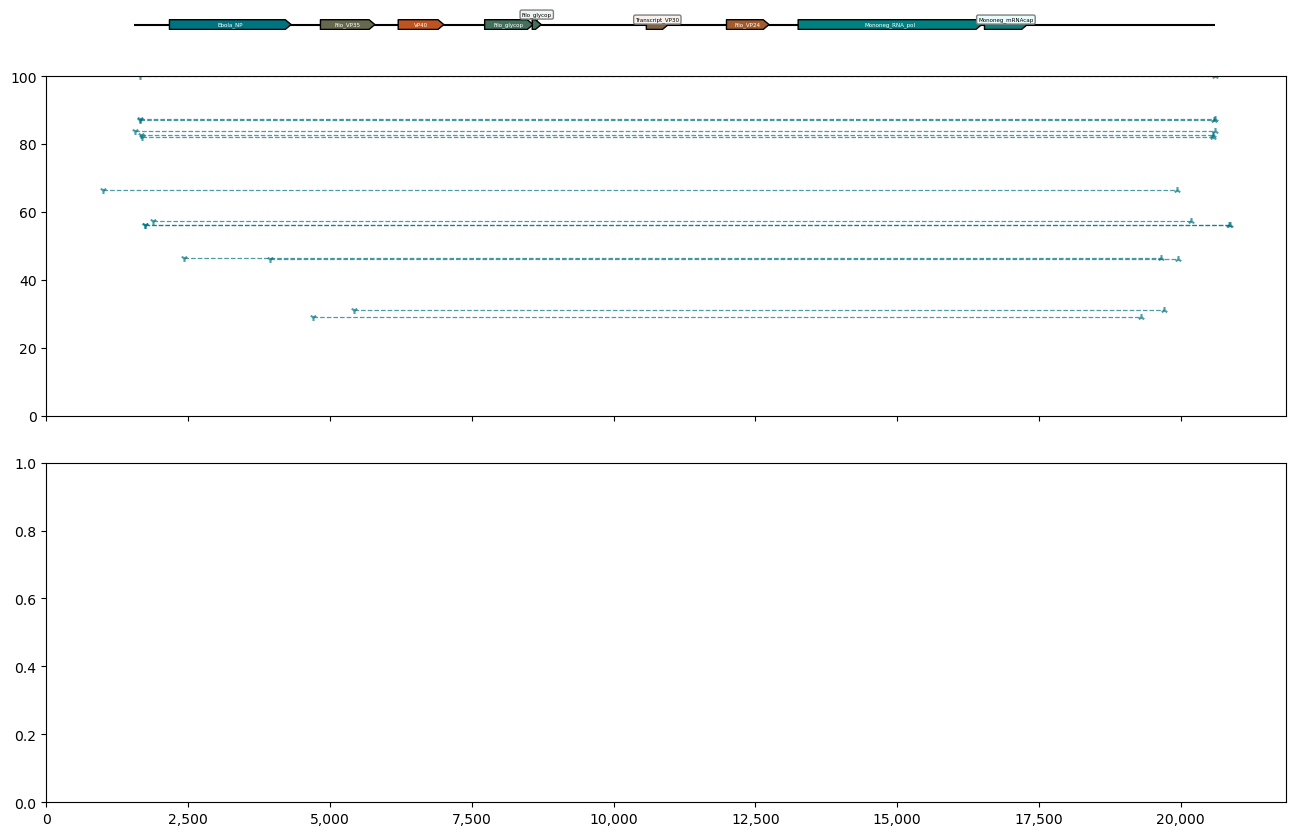

In [50]:
# for (i,j) in :
fig,ax=plt.subplots(3,1,figsize=(16,0.3+5+5),
                    height_ratios=[0.3,5,5],sharex=True)
ax:List[Axes]
i,j = sort_genome(genomes,sort_rdrps)[0]
'''
i: genome id,
j: identity% to ref genome 
'''
idf=domains[domains['genome_name']==i]
# for i,idf in domains.groupby('genome_name'):
    # sequence_length=idf.iloc[0]['genome_length']
if (idf['domain_accession']==ref_accession).any():
    #TODO better decision of genome length & del_start
    rdrp_start=idf[idf['domain_accession']==ref_accession].iloc[0]['start']
    rdrp_hmm_start=idf[idf['domain_accession']==ref_accession].iloc[0]['hmmStart']
    del_start=ref-(rdrp_start-rdrp_hmm_start*3)
else:
    # del_start=ref-idf.iloc[0]['genome_length']/2
    del_start=(sequence_length-idf.iloc[0]['genome_length'])/2
    # print(f'no rdrp warning:{i}') #TODO unified log system

features=[]
for _,d in idf.iterrows():
    # annot=domains[domains['domain_accession']==d['domain_accession']].iloc[0]['domain_annotation'].split(':')[0]
    strand=+1 if d['strand']=='SENSE' else -1
    a_=d['domain_annotation'].split(':')[0]
    if d['domain_accession'] in ref_palette:
        identity=identities_dict[d['domain_accession']].get(i,noalign_holder)/100
        _pseudo_identity=norm(identity)
        color=ref_palette[d['domain_accession']](_pseudo_identity)
    else:
        color=missing_color_map(1.)#missing_palette[d['domain_accession']]
    features.append(GraphicFeature(start=d['start']+del_start, end=d['end']+del_start, strand=strand, color=color,
                                linewidth=1, thickness=7,label=a_,fontdict={'fontsize':4})) #,linecolor=color
                # label=d['domain_accession'],fontdict={'fontsize':15}))
record = GraphicRecord(sequence_length=sequence_length, feature_level_height=0,features=features)
record.plot(ax=ax[0],figure_width=20)
ax[0].set_facecolor("white")
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
# ax[0].annotate(i+f'|{j}' ,(-100,0.2), xycoords='data', annotation_clip=False, ha='left',fontsize=8) 
hide_axes(ax[0],0+del_start,idf.iloc[0]['genome_length']+del_start,sequence_length=sequence_length)

ends_df=get_ends_df(domains,identities_dict,ref_accession)

for (i,j) in sort_genome(genomes,sort_rdrps):
    '''
    i: genome id,
    j: identity% to ref genome 
    '''
    if i in ends_df.index:
        idf=domains[domains['genome_name']==i]
        # for i,idf in domains.groupby('genome_name'):
            # sequence_length=idf.iloc[0]['genome_length']
        if (idf['domain_accession']==ref_accession).any():
            #TODO better decision of genome length & del_start
            rdrp_start=idf[idf['domain_accession']==ref_accession].iloc[0]['start']
            rdrp_hmm_start=idf[idf['domain_accession']==ref_accession].iloc[0]['hmmStart']
            del_start=ref-(rdrp_start-rdrp_hmm_start*3)
        else:
            # del_start=ref-idf.iloc[0]['genome_length']/2
            del_start=(sequence_length-idf.iloc[0]['genome_length'])/2
            # print(f'no rdrp warning:{i}') #TODO unified log system
        identity=ends_df.loc[i]['identity']
        b,e=0+del_start,idf.iloc[0]['genome_length']+del_start
        # features=[]
        # for _,d in idf.iterrows():
        #     strand=+1 if d['strand']=='SENSE' else -1
        #     a_=d['domain_annotation'].split(':')[0]
        #     if d['domain_accession'] in ref_palette:
        #         identity=identities_dict[d['domain_accession']].get(i,noalign_holder)/100
        #         _pseudo_identity=norm(identity)
        #         color=ref_palette[d['domain_accession']](_pseudo_identity)
        #     else:
        #         color=missing_color_map(1.)#missing_palette[d['domain_accession']]
        #     features.append(GraphicFeature(start=d['start']+del_start, end=d['end']+del_start, strand=strand, color=color,
        #                                 linewidth=1, thickness=7)) #,linecolor=color
        #                 # label=d['domain_accession'],fontdict={'fontsize':15}))
        # record = GraphicRecord(sequence_length=sequence_length, feature_level_height=0,features=features)
        # record.plot(ax=ax[c],figure_width=20)
        # ax[c].set_facecolor("white")
        # ax[c].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
        # ax[c].annotate(i+f'|{j}' ,(-100,0.2), xycoords='data', annotation_clip=False, ha='left',fontsize=8) 
        # hide_axes(ax[c],,sequence_length=sequence_length)
        color=ref_palette['PF05505'](identity)
        ax[1].scatter(b,identity,color=color,s=25,marker='1',alpha=0.7)
        ax[1].scatter(e,identity,color=color,s=25,marker='2',alpha=0.7)
        ax[1].hlines(y=identity,xmin=b,xmax=e,
                    color=color,linestyles='--',linewidth=0.9,alpha=0.7,)
        ax[1].set_ylim(0,100)




# plt.close('all')
# fig,ax1=plt.subplots(1,1,figsize=(8,8))
# ax1:Axes


# ax1.text(0.01, 0.98, "5' end", transform=ax1.transAxes, va='bottom', ha='left',fontsize=12)
# ax1.text(0.01, 0.02, "3' end", transform=ax1.transAxes, va='top', ha='left',fontsize=12)
# ax1.set_xlabel('identity',loc='center',labelpad=-5,fontsize=12)
# ax1.set_title(f'{k}',fontsize=18)
# ax1.text(0.95, 0.98, f"ref-genome: {ref_genome}\nref-domain: {ref_accession}", 
#             transform=ax1.transAxes, va='top', ha='right')

# ax1.spines['bottom'].set_position('zero')
# ax1.spines['right'].set_color('none')
# ax1.spines['top'].set_color('none')
# ax1.set_xlim(101,0)
# ax1.set_xticks(np.linspace(100,0,6))

# fig.tight_layout()
# fig.savefig(f'{k}-{suffix}.pdf')
# plt.close('all')

In [46]:
a_

'Filo_VP35'

In [20]:
idf

,genome_name,genome_length,domain_accession,strand,start,end,hmmStart,hmmEnd,evalue,domain_annotation
0,EBOV||AF086833,18959,PF06389,SENSE,10348,11098,1,262,2.100000e-141,Filo_VP24:Filovirus membrane-associated protei...
1,EBOV||AF086833,18959,PF11507,SENSE,8935,9322,1,131,2.000000e-69,Transcript_VP30:Ebola virus-specific transcrip...
2,EBOV||AF086833,18959,PF07447,SENSE,4560,5364,1,292,3.900000e-145,VP40:Matrix protein VP40
3,EBOV||AF086833,18959,PF01611,SENSE,6923,7082,342,395,1.200000e-16,Filo_glycop:Filovirus glycoprotein
4,EBOV||AF086833,18959,PF01611,SENSE,6084,6939,1,347,2.700000e-150,Filo_glycop:Filovirus glycoprotein
5,EBOV||AF086833,18959,PF00946,SENSE,11611,14848,1,1068,0.000000e+00,Mononeg_RNA_pol:Mononegavirales RNA dependent ...
6,EBOV||AF086833,18959,PF14318,SENSE,14896,15652,1,240,2.500000e-73,Mononeg_mRNAcap:Mononegavirales mRNA-capping r...
7,EBOV||AF086833,18959,PF05505,SENSE,527,2672,1,753,0.000000e+00,Ebola_NP:Ebola nucleoprotein
8,EBOV||AF086833,18959,PF02097,SENSE,3189,4149,1,342,2.600000e-184,Filo_VP35:Filoviridae VP35


In [56]:
subdf

,genome_name,genome_length,domain_accession,strand,start,end,hmmStart,hmmEnd,evalue,domain_annotation,refbe
24,TAPV||BR001752,16009,PF00429,SENSE,6032,6395,424,550,0.0044,TLV_coat:ENV polyprotein (coat polyprotein),"(-4911, -4548)"


(array([37., 36., 36., 37., 36., 36., 37., 36., 36., 37.]),
 array([-4911. , -4874.7, -4838.4, -4802.1, -4765.8, -4729.5, -4693.2,
        -4656.9, -4620.6, -4584.3, -4548. ]),
 <BarContainer object of 10 artists>)

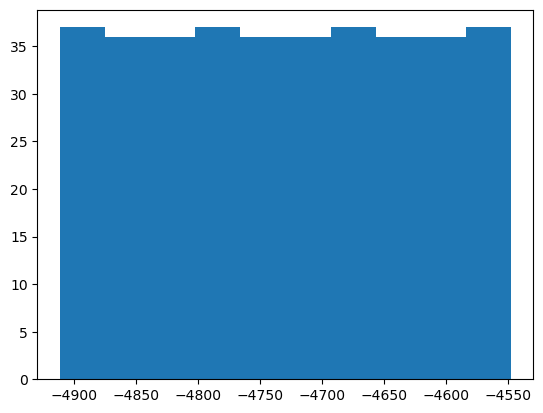

In [53]:
plt.hist(_)

In [36]:
ref_pos

{'BDBV||FJ217161': {'start': 11597, 'end': 14834},
 'BOMV||MF319185': {'start': 11696, 'end': 14933},
 'EBOV||AF086833': {'start': 11611, 'end': 14848},
 'FIWIV||MN510772': {'start': 7386, 'end': 10494},
 'HUJV||MG599981': {'start': 7837, 'end': 10942},
 'KNDV||MW093492': {'start': 6766, 'end': 9865},
 'LLOV||JF828358': {'start': 12254, 'end': 15488},
 'MARV||DQ217792': {'start': 11508, 'end': 14754},
 'MLAV||KX371887': {'start': 11382, 'end': 14631},
 'OBLV||MN510773': {'start': 8552, 'end': 11654},
 'RAVV||DQ447649': {'start': 11507, 'end': 14753},
 'RESTV||AF522874': {'start': 11580, 'end': 14817},
 'SUDV||AY729654': {'start': 11568, 'end': 14805},
 'TAFV||FJ217162': {'start': 11596, 'end': 14833},
 'TAPV||BR001752': {'start': 9319, 'end': 12568},
 'XILV||MG599980': {'start': 10832, 'end': 14033}}

In [12]:
ref_genome_dict


{'zika': 'ZIKV||AY632535',
 'ebola': 'EBOV||AF086833',
 'measles': 'MeV||AB016162'}

In [17]:
for k in ref_genome_dict:
    plot_genlength(k,ref_genome_dict[k],ref_accession_dict[k])
    break
# ax1.set_xlim(100,0)

In [66]:
ax1.transAxes

In [31]:
# def get_sequence_length(domains:pd.DataFrame,ref_accession:str,paddding=1000):

# left,right=left_.max(),right_.max()
# no_ref_accession_genome=get_no_ref_accession_genome(domains,ref_accession)

,identity,5-length,3-length
EBOV||AF086833,100.0,11608.0,7351.0
BDBV||FJ217161,87.3,11594.0,7346.0
TAFV||FJ217162,87.0,11593.0,7342.0
BOMV||MF319185,83.9,11693.0,7350.0
RESTV||AF522874,82.8,11577.0,7314.0
SUDV||AY729654,82.0,11565.0,7310.0
LLOV||JF828358,66.5,12251.0,6676.0
MLAV||KX371887,57.4,11379.0,6921.0
MARV||DQ217792,56.2,11505.0,7606.0
RAVV||DQ447649,56.3,11504.0,7610.0


In [16]:
identities_dict[ref_accession]

{'EBOV||AF086833': 100.0,
 'BDBV||FJ217161': 87.3,
 'TAFV||FJ217162': 87.0,
 'BOMV||MF319185': 83.9,
 'RESTV||AF522874': 82.8,
 'SUDV||AY729654': 82.0,
 'LLOV||JF828358': 66.5,
 'MLAV||KX371887': 57.4,
 'MARV||DQ217792': 56.2,
 'RAVV||DQ447649': 56.3,
 'TAPV||BR001752': 46.1,
 'XILV||MG599980': 46.6,
 'HUJV||MG599981': 31.1,
 'OBLV||MN510773': 29.2}

8549

In [93]:
mcolors.to_rgba('red')

(1.0, 0.0, 0.0, 1.0)

In [107]:
k='zika'
ref_genome=ref_genome_dict[k]
ref_accession=ref_accession_dict[k]
suffix='synteney_1'
for k in ref_genome_dict:
    plot_synteny_v1(k,ref_genome_dict[k],ref_accession_dict[k],
                    corr_color_list=['green','black','red'],missing_color='purple',
                    suffix=suffix)  